In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [3]:
# load stopwords
from sklearn.feature_extraction import text
text_file = open('/Users/zejiachen/Desktop/fall 2021/QTM 340/Final Project/Notebook/jockers_stopwords.txt') # your path will be different!
jockers_words = text_file.read().split()
new_stopwords = text.ENGLISH_STOP_WORDS.union(jockers_words)

In [4]:
# remove stemmed words
english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

In [5]:
df = pd.read_csv('/Users/zejiachen/Desktop/Sspring 2022/IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:xlabel='sentiment'>

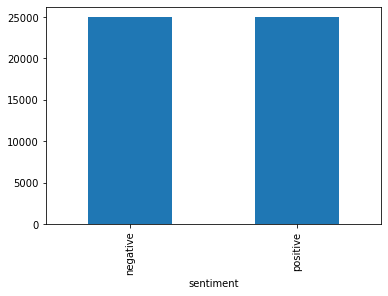

In [6]:
df.groupby(['sentiment']).size().plot.bar()

---

## Data Cleaning

**Text Normalization**

In [18]:
# load stopwords
from sklearn.feature_extraction import text
text_file = open('/Users/zejiachen/Desktop/fall 2021/QTM 340/Final Project/Notebook/jockers_stopwords.txt') # your path will be different!
jockers_words = text_file.read().split()
stopword_list = text.ENGLISH_STOP_WORDS.union(jockers_words)


In [20]:
#Setting English stopwords
nltk.download('stopwords')
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zejiachen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Tokenization of text
tokenizer=ToktokTokenizer()

**Removing html strip and noisy text**

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


df['review']=df['review'].apply(denoise_text)

**Removing Special Characters**

In [12]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

df['review']=df['review'].apply(remove_special_characters)

**Text Stemming**

In [13]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

**Removing Stopwords**

In [22]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'what', 'now', "mustn't", 'only', 'and', 'being', "weren't", 'is', 'will', 'where', 'until', 'd', 'were', "haven't", 'mightn', 'do', "wouldn't", 'o', 'they', 'nor', 'down', 'was', 'have', 'itself', 'over', 'our', 're', 'too', 'herself', "wasn't", "needn't", 'up', 'yourself', 'did', 'your', 'between', "didn't", 'a', 'both', 'had', 'if', 'won', 'other', 'some', 'after', 'once', 'same', 'weren', 'doing', 'because', 'further', 'himself', 'does', "you'd", 'from', 'no', 'yourselves', 'them', 'how', 'as', 'which', "hadn't", 'isn', 'him', 'the', 'at', 'when', 'shan', "won't", 'any', 'ourselves', 'haven', "mightn't", 'about', "shan't", 'hasn', "you'll", "isn't", "you've", 'those', 'again', 's', 'there', 'that', 'ain', "should've", 'before', 'myself', 'above', 'each', 'its', "aren't", 'against', 'didn', 'am', 'who', 'doesn', 'with', 'an', 'so', 'than', 'few', 'under', 'own', 'all', 'into', 'needn', 'themselves', 'while', 'by', 'in', 'here', 'through', 'to', 'out', 'ours', 'hadn', "she's", 'thei

---
## Generating document-term matrix

In [78]:
# train set: 40000 observation, validation set: 5000 observation, final test set: 5000 observation
np.random.seed(0)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=1), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

review_trn = df_train[['review']]
sentiment_trn = df_train[['sentiment']]

review_val = df_val[['review']]
sentiment_val = df_val[['sentiment']]

review_test = df_test[['review']]
sentiment_test = df_test[['sentiment']]

40000 5000 5000


In [79]:
review_trn['review'][0]

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [46]:
review_val['review'][27192]

'origin relax watch truli memor anim sequenc unfortun sequel worst dtv sequel complet lack sparkleth biggest letdown lack stori like bell magic world charact told seri vignett magic world margin better still manag make mess stori vignett see mice work person think antic jaq gu redeem merit thi movieth first vignett best cinderella get use princess thi best becaus mice funniest worst vignett jaq turn human cute time ha lack imagin last vignett anastasia fall love wa also cute problem wa couldnt imagin anastasia friendli cinderella consid meaner stepsist thi wa also mar rather ridicul subplot lucif fall love pompomth incident music wa veri pleasant listen tohowev hate song realli uninspir noth like beauti tchaikovski inspir melodi originalth charact strongest develop cinderella still care lost sincer lot charm origin though doe wear veri pretti cloth duke truli funni moment werent enough save film likewis prudenc king mention mice redeem merit movi alon contribut film cute say also anim 

In [52]:
review_test['review'][27436]

'dure make thi movi onc caught statement televis someth like killinggnget take nazismso comprehens thi movi wa begin get notion nazism recent see thi movi tvversion thi filter befor wasnt difficult see thisstrang enough havent met thi way interpret film ever sinc first heard itthes thing found four shade brown four stori lack empathi lead disaster1 crematorywork show realist empathi dead anim say goodby crematoryroom deal death fire almost like cheer game serious death fire emphas father hi boy accordingli ignor push button lead disast injur hi father severelyposs lesson import show young adequ emot grow need know behavior lead disast emot lead good2th magician maneuv hi wife like invis puppet think ha begun cut string master hand reach person integr joy pull hard back desol despairtheir son ha tri revolt creat hi life perfect good tast opposit hi parent bad tast real problem carri within far comprehens hi father behavior pass suffoc hi wife hi spotless environmentposs lesson oppress b

**Bags of words model**

In [64]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(review_trn['review'])
#transformed validation reviews
cv_val_reviews=cv.transform(review_val['review'])
#transformed test reviews
cv_test_reviews=cv.transform(review_test['review'])

print('BOW_cv_train:' ,cv_train_reviews.shape)
print('BOW_cv_validation:', cv_val_reviews.shape)
print('BOW_cv_test:', cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature name

BOW_cv_train: (40000, 6194496)
BOW_cv_validation: (5000, 6194496)
BOW_cv_test: (5000, 6194496)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

In [66]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(review_trn['review'])
#transformed validation reviews
tv_val_reviews=tv.transform(review_val['review'])
#transformed test reviews
tv_test_reviews=tv.transform(review_test['review'])
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_validation:',tv_val_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6194496)
Tfidf_validation: (5000, 6194496)
Tfidf_test: (5000, 6194496)


**Labeling the sentiment text**

In [85]:
#labeling the sentient data
lb=LabelBinarizer()

#transformed sentiment data
sentiment_trnBi=lb.fit_transform(sentiment_trn['sentiment'])
sentiment_valBi = lb.transform(sentiment_val['sentiment'])
sentiment_testBi = lb.transform(sentiment_test['sentiment'])
print('sentiment_train: ', sentiment_trnBi.shape)
print('sentiment_val: ', sentiment_valBi.shape)
print('sentiment_test: ', sentiment_testBi.shape)

sentiment_train:  (40000, 1)
sentiment_val:  (5000, 1)
sentiment_test:  (5000, 1)


---
## Logistic Regression

Build logistic regression model for both bag of words and tfidf features

In [90]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,sentiment_trnBi)
print(lr_bow)

#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,sentiment_trnBi)
print(lr_tfidf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


Accuracy of the model on **validation set**

In [93]:
#Predicting the model for bag of words
lr_bow_predict_val=lr.predict(cv_val_reviews)
print(lr_bow_predict_val)

##Predicting the model for tfidf features
lr_tfidf_predict_val=lr.predict(tv_val_reviews)
print(lr_tfidf_predict_val)

[0 1 0 ... 1 1 0]
[0 1 0 ... 1 1 0]


In [96]:
#Accuracy score for bag of words
lr_bow_score_val=accuracy_score(sentiment_valBi,lr_bow_predict_val)
print("lr_bow_score on validation :",lr_bow_score_val)
#Accuracy score for tfidf features
lr_tfidf_score_val=accuracy_score(sentiment_valBi,lr_tfidf_predict_val)
print("lr_tfidf_score on validation :",lr_tfidf_score_val)

lr_bow_score on validation : 0.7402
lr_tfidf_score on validation : 0.7424


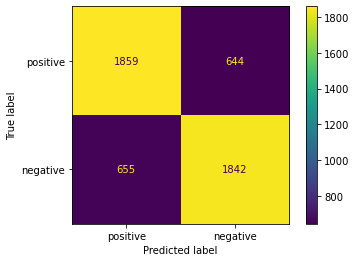

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#confusion matrix for bag of words
cm_bow=confusion_matrix(sentiment_valBi,lr_bow_predict_val,labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=['positive','negative'])

disp.plot()
plt.show()

[[1838  665]
 [ 623 1874]]


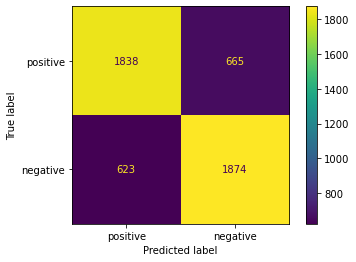

In [103]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(sentiment_valBi,lr_tfidf_predict_val,labels=[1,0])
print(cm_tfidf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['positive','negative'])

disp.plot()
plt.show()

Accuracy of the model on **test set**

In [97]:
#Predicting the model for bag of words
lr_bow_predict_test=lr.predict(cv_test_reviews)
print(lr_bow_predict_test)

##Predicting the model for tfidf features
lr_tfidf_predict_test=lr.predict(tv_test_reviews)
print(lr_tfidf_predict_test)

[1 1 1 ... 0 0 1]
[1 1 1 ... 0 0 1]


In [99]:
#Accuracy score for bag of words
lr_bow_score_test=accuracy_score(sentiment_testBi,lr_bow_predict_test)
print("lr_bow_score on test set :",lr_bow_score_test)
#Accuracy score for tfidf features
lr_tfidf_score_test=accuracy_score(sentiment_testBi,lr_tfidf_predict_test)
print("lr_tfidf_score on test set :",lr_tfidf_score_test)

lr_bow_score on test set : 0.7516
lr_tfidf_score on test set : 0.749


[[1882  610]
 [ 632 1876]]


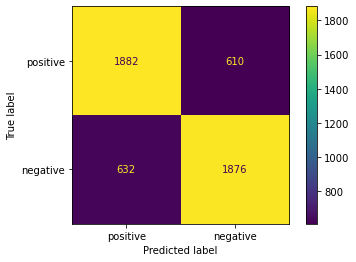

In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#confusion matrix for bag of words
cm_bow=confusion_matrix(sentiment_testBi,lr_bow_predict_test,labels=[1,0])
print(cm_bow)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=['positive','negative'])

disp.plot()
plt.show()

[[1848  644]
 [ 611 1897]]


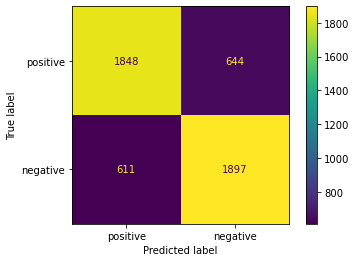

In [106]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(sentiment_testBi,lr_tfidf_predict_test,labels=[1,0])
print(cm_tfidf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['positive','negative'])

disp.plot()
plt.show()

---
## How Logistic Regression makes its decisions (P-val & weight)